In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default() 
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
!pip show tensorflow

Name: tensorflow
Version: 1.15.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: google-pasta, gast, keras-preprocessing, tensorboard, tensorflow-estimator, grpcio, opt-einsum, termcolor, numpy, keras-applications, wrapt, wheel, absl-py, astor, protobuf, six
Required-by: stable-baselines, magenta, fancyimpute


In [0]:
!pip show keras

Name: Keras
Version: 2.2.5
Summary: Deep Learning for humans
Home-page: https://github.com/keras-team/keras
Author: Francois Chollet
Author-email: francois.chollet@gmail.com
License: MIT
Location: /usr/local/lib/python3.6/dist-packages
Requires: keras-applications, scipy, pyyaml, h5py, numpy, six, keras-preprocessing
Required-by: textgenrnn, keras-vis, kapre, fancyimpute


In [0]:
os.chdir('/content/drive/My Drive/BRATS-2/Image_Data/HG')


In [0]:
!pip3 install SimpleITK


     |████████████████████████████████| 42.5MB 58.8MB/s 


In [0]:
import SimpleITK as sitk
import numpy as np



In [0]:
import os
path = '/content/drive/My Drive/BRATS-2/Image_Data/HG/0001'
p = os.listdir(path)
p.sort(key=str.lower)
arr=[]

for i in range(len(p)):
  if 'more' in p[i] or 'OT' in p[i]:
    if p[i] != '.DS_Store':
      p1 = os.listdir(path+'/'+p[i])
      img = sitk.ReadImage(path+'/'+p[i]+'/'+p1[0])
      Y_labels = sitk.GetArrayFromImage(img) 
      print(Y_labels.shape)
  else:
    if p[i] != '.DS_Store':
      p1 = os.listdir(path+'/'+p[i])
      p1.sort()
      img = sitk.ReadImage(path + '/' + p[i]+'/'+p1[-1])
      arr.append(sitk.GetArrayFromImage(img))
      
data = np.zeros((Y_labels.shape[1],Y_labels.shape[0],Y_labels.shape[2],4))
for i in range(Y_labels.shape[1]):
  data[i,:,:,0] = arr[0][:,i,:]
  data[i,:,:,1] = arr[1][:,i,:]
  data[i,:,:,2] = arr[2][:,i,:]
  data[i,:,:,3] = arr[3][:,i,:]

(176, 216, 160)


Populating the interactive namespace from numpy and matplotlib


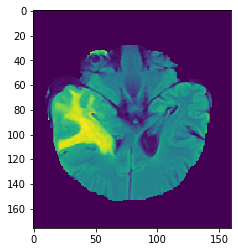

ValueError: ignored

In [0]:
%pylab inline
import matplotlib.pyplot as plt
img = data[126,:,:,0]
imgplot = plt.imshow(img)
plt.show()
plt.imsave('slice_126_4',img,cmap='gray')

Populating the interactive namespace from numpy and matplotlib


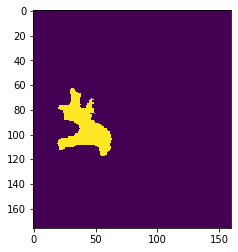

In [0]:

%pylab inline
import matplotlib.pyplot as plt
img = Y_labels[:,126,:]
imgplot = plt.imshow(img)
plt.show()
#plt.imsave('slice_126_GT',img,cmap='gray')

In [0]:
def model_gen(input_dim,x,y,slice_no):
  X1 = []
  X2 = []
  Y = []
  
  for i in range(int((input_dim)/2),y.shape[0]-int((input_dim)/2)):
    for j in range(int((input_dim)/2),y.shape[2]-int((input_dim)/2)):
      #Filtering all 0 patches
      if(x[i-16:i+17,j-16:j+17,:].any != 0):
        X2.append(x[i-16:i+17,j-16:j+17,:])
        X1.append(x[i-int((input_dim)/2):i+int((input_dim)/2)+1,j-int((input_dim)/2):j+int((input_dim)/2)+1,:])
        Y.append(y[i,slice_no,j])
      
      
  X1 = np.asarray(X1)
  X2 = np.asarray(X2)
  Y = np.asarray(Y)
  d = [X1,X2,Y]
  return d

In [0]:
def data_gen(data,y,slice_no,model_no):
  d = []
  x = data[slice_no]
  #filtering all 0 slices and non-tumor slices
  if(x.any() != 0 and y.any() != 0):
    if(model_no == 0):
      X1 = []
      for i in range(16,159):
        for j in range(16,199):
          if(x[i-16:i+17,j-16:j+17,:].all != 0):
            X1.append(x[i-16:i+17,j-16:j+17,:])
      Y1 = []
      for i in range(16,159):
        for j in range(16,199):
          if(x[i-16:i+17,j-16:j+17,:].all != 0):
            Y1.append(y[i,slice_no,j]) 
      X1 = np.asarray(X1)
      Y1 = np.asarray(Y1)
      d = [X1,Y1]
    elif(model_no == 1):
      d = model_gen(65,x,y,slice_no)
    elif(model_no == 2):
      d = model_gen(56,x,y,slice_no)
    elif(model_no == 3):
      d = model_gen(53,x,y,slice_no)  
    
  return d

In [0]:
import keras
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Lambda,Concatenate
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, Add
from keras.models import Model
from keras import regularizers
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.initializers import glorot_normal
#import pydot
from IPython.display import SVG
from keras import regularizers

from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model



Using TensorFlow backend.


In [0]:
def two_path(X_input):
  # Local path Conv1
  X = Conv2D(64,(7,7),strides=(1,1),padding='valid', kernel_regularizer=regularizers.l2(0.01),
               activity_regularizer=regularizers.l1(0.01) )(X_input)
  # Batch-norm
  X = BatchNormalization()(X)
  X1 = Conv2D(64,(7,7),strides=(1,1),padding='valid', kernel_regularizer=regularizers.l2(0.01),
               activity_regularizer=regularizers.l1(0.01))(X_input)
  X1 = BatchNormalization()(X1)
  # Max-out
  X = layers.Maximum()([X,X1])
  X = Conv2D(64,(4,4),strides=(1,1),padding='valid',activation='relu', kernel_regularizer=regularizers.l2(0.01),
               activity_regularizer=regularizers.l1(0.01))(X)
  
  # Global path
  X2 = Conv2D(160,(13,13),strides=(1,1),padding='valid', kernel_regularizer=regularizers.l2(0.01),
               activity_regularizer=regularizers.l1(0.01))(X_input)
  X2 = BatchNormalization()(X2)
  X21 = Conv2D(160,(13,13),strides=(1,1),padding='valid', kernel_regularizer                                                     =regularizers.l2(0.01),
               activity_regularizer=regularizers.l1(0.01))(X_input)
  X21 = BatchNormalization()(X21)
  # Max-out
  X2 = layers.Maximum()([X2,X21])
  
  # Local path Conv2
  X3 = Conv2D(64,(3,3),strides=(1,1),padding='valid', kernel_regularizer=regularizers.l2(0.01),
               activity_regularizer=regularizers.l1(0.01))(X)
  X3 = BatchNormalization()(X3)
  X31 =  Conv2D(64,(3,3),strides=(1,1),padding='valid',  kernel_regularizer=regularizers.l2(0.01),
               activity_regularizer=regularizers.l1(0.01))(X)
  X31 = BatchNormalization()(X31)
  X = layers.Maximum()([X3,X31])
  X = Conv2D(64,(2,2),strides=(1,1),padding='valid',activation='relu', kernel_regularizer=regularizers.l2(0.01),
               activity_regularizer=regularizers.l1(0.01))(X)
  
  # Merging the two paths
  X = Concatenate()([X2,X])

  return X

In [0]:
def two_path(X_input):
  # Local path Conv1
  X = Conv2D(64,(7,7),strides=(1,1),padding='valid', kernel_regularizer=regularizers.l2(0.01),
               activity_regularizer=regularizers.l1(0.01) )(X_input)
  # Batch-norm
  X = BatchNormalization()(X)
  X1 = Conv2D(64,(7,7),strides=(1,1),padding='valid', kernel_regularizer=regularizers.l2(0.01),
               activity_regularizer=regularizers.l1(0.01))(X_input)
  X1 = BatchNormalization()(X1)
  # Max-out
  X = layers.Maximum()([X,X1])
  X = Conv2D(64,(4,4),strides=(1,1),padding='valid',activation='relu', kernel_regularizer=regularizers.l2(0.01),
               activity_regularizer=regularizers.l1(0.01))(X)
  
  # Global path
  X2 = Conv2D(160,(13,13),strides=(1,1),padding='valid', kernel_regularizer=regularizers.l2(0.01),
               activity_regularizer=regularizers.l1(0.01))(X_input)
  X2 = BatchNormalization()(X2)
  X21 = Conv2D(160,(13,13),strides=(1,1),padding='valid', kernel_regularizer                                                     =regularizers.l2(0.01),
               activity_regularizer=regularizers.l1(0.01))(X_input)
  X21 = BatchNormalization()(X21)
  # Max-out
  X2 = layers.Maximum()([X2,X21])
  
  # Local path Conv2
  X3 = Conv2D(64,(3,3),strides=(1,1),padding='valid', kernel_regularizer=regularizers.l2(0.01),
               activity_regularizer=regularizers.l1(0.01))(X)
  X3 = BatchNormalization()(X3)
  X31 =  Conv2D(64,(3,3),strides=(1,1),padding='valid',  kernel_regularizer=regularizers.l2(0.01),
               activity_regularizer=regularizers.l1(0.01))(X)
  X31 = BatchNormalization()(X31)
  X = layers.Maximum()([X3,X31])
  X = Conv2D(64,(2,2),strides=(1,1),padding='valid',activation='relu', kernel_regularizer=regularizers.l2(0.01),
               activity_regularizer=regularizers.l1(0.01))(X)
  
  # Merging the two paths
  X = Concatenate()([X2,X])

  return X



In [0]:
def input_cascade(input_shape1,input_shape2):
  
  X1_input = Input(input_shape1)
  # 1st two-path of cascade
  X1 = two_path(X1_input)
  X1 = Conv2D(5,(21,21),strides=(1,1),padding='valid',activation='relu', kernel_regularizer=regularizers.l2(0.01),
               activity_regularizer=regularizers.l1(0.01))(X1)
  X1 = BatchNormalization()(X1)
  
  X2_input = Input(input_shape2)
  # Concatenating the output of 1st to input of 2nd
  X2_input1 = Concatenate()([X1,X2_input])
  #X2_input1 = Input(tensor = X2_input1)
  X2 = two_path(X2_input1)
  # Fully convolutional softmax classification
  X2 = Conv2D(5,(21,21),strides=(1,1),padding='valid',  kernel_regularizer=regularizers.l2(0.01),
               activity_regularizer=regularizers.l1(0.01))(X2)
  X2 = BatchNormalization()(X2)
  X2 = Activation('softmax')(X2)
  
  model = Model(inputs=[X1_input,X2_input],outputs=X2)
  return model

In [0]:
m1 = input_cascade((65,65,4),(33,33,4))
m1.summary()












Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 65, 65, 4)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 59, 59, 64)   12608       input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 59, 59, 64)   12608       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 59, 59, 64)   256         conv2d_1[0][0]                   
_________________________________________________________________________________

In [0]:
from sklearn.utils import class_weight


In [0]:
from keras import optimizers
import keras.backend as K


In [0]:

def f1_score(y_true, y_pred):

    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c2 = K.sum(K.round(K.clip(y_true, 0, 1)))
    c3 = K.sum(K.round(K.clip(y_pred, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0:
        return 0

    # How many selected items are relevant?
    precision = c1 / c2

    # How many relevant items are selected?
    recall = c1 / c3

    # Calculate f1_score
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score

In [0]:
from sklearn import metrics
from sklearn.utils import class_weight



In [0]:
def data_gen2(path,slice_no,model_no):
  p = os.listdir(path)
  p.sort(key=str.lower)
  arr = []
  for i in range(len(p)):
    if 'more' in p[i] or 'OT' in p[i]:
      if p[i] != '.DS_Store':
        p1 = os.listdir(path+'/'+p[i])
        img = sitk.ReadImage(path+'/'+p[i]+'/'+p1[0])
        y = sitk.GetArrayFromImage(img)    

    else:
      if p[i] != '.DS_Store':
        p1 = os.listdir(path+'/'+p[i])
        p1.sort()
        img = sitk.ReadImage(path + '/' + p[i]+'/'+p1[-1])
        arr.append(sitk.GetArrayFromImage(img))
  data = np.zeros((196,176,216,4))
  for i in range(196):
    data[i,:,:,0] = arr[0][:,i,:]
    data[i,:,:,1] = arr[1][:,i,:]
    data[i,:,:,2] = arr[2][:,i,:]
    data[i,:,:,3] = arr[3][:,i,:]
  x = data[slice_no]
  
  if(model_no == 0):
    X1 = []
    for i in range(16,159):
      for j in range(16,199):
        X1.append(x[i-16:i+17,j-16:j+17,:])
    Y1 = []
    for i in range(16,159):
      for j in range(16,199):
        Y1.append(y[i,slice_no,j]) 
    X1 = np.asarray(X1)
    Y1 = np.asarray(Y1)
    d = [X1,Y1]
  elif(model_no == 1):
    d = model_gen(65,x,y,slice_no)
  elif(model_no == 2):
    d = model_gen(56,x,y,slice_no)
  elif(model_no == 3):
    d = model_gen(53,x,y,slice_no)  
    
  return d

In [0]:
d = data_gen2('/content/drive/My Drive/BRATS-2/Image_Data/LG/0001',100,1)

In [0]:
len(d[0])


17024

In [0]:
y = np.zeros((17024,1,1,5))

In [0]:
for i in range(y.shape[0]):
  y[i,:,:,d[2][i]] = 1
  
sample = np.zeros((5,1))
for i in range(5):
  sample[i] = np.sum(y[:,:,:,i])
print(sample/np.sum(sample))



[[9.61231203e-01]
 [2.13228383e-02]
 [4.34680451e-03]
 [1.25117481e-02]
 [5.87406015e-04]]


In [0]:
X1 = np.asarray(d[0])
X1.shape

(17024, 65, 65, 4)

In [0]:
X2 = np.asarray(d[1])
X2.shape

(17024, 33, 33, 4)

In [0]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(d[2]),
                                                 d[2])

class_weights



array([2.08066487e-01, 9.37961433e+00, 4.60108108e+01, 1.59849765e+01,
       3.40480000e+02])

In [0]:
m1.input_shape


[(None, 65, 65, 4), (None, 33, 33, 4)]

In [0]:
import tensorflow as tf

In [0]:
import h5py
import numpy as np

In [0]:
#K.clear_session()
print(X2.sum())

11776462582.0


In [0]:
#m0.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
#m0_info = m0.fit(X2,y,epochs=100,batch_size=1024,class_weight = class_weights)

In [0]:
m1.compile(loss='categorical_crossentropy',optimizer='adam',metrics=[f1_score])


In [0]:
m1_info = m1.fit([X1,X2],y,epochs=20,batch_size=256,class_weight = class_weights)


Epoch 1/20
17024/17024 [==============================] - 79s 5ms/step - loss: 46773537.7744 - f1_score: 0.9612
Epoch 2/20
17024/17024 [==============================] - 76s 4ms/step - loss: 25645085.9173 - f1_score: 0.9612
Epoch 3/20
17024/17024 [==============================] - 76s 4ms/step - loss: 25117578.0602 - f1_score: 0.9612
Epoch 4/20
17024/17024 [==============================] - 76s 4ms/step - loss: 27430542.3459 - f1_score: 0.9612
Epoch 5/20
17024/17024 [==============================] - 76s 4ms/step - loss: 28089644.2256 - f1_score: 0.9612
Epoch 6/20
10240/17024 [=================>............] - ETA: 30s - loss: 25190007.8500 - f1_score: 0.9628

In [0]:

m1.save('trial_InputCascade_acc.h5')

In [0]:
# info = []
# for i in range(0,data.shape[0]):
#   d = data_gen(data,Y_labels,i,3)
#   if(len(d) != 0):
#     y = np.zeros((d[2].shape[0],1,1,5))
#     for j in range(y.shape[0]):
#       y[j,:,:,d[2][j]] = 1
#     X1 = d[0]
#     X2 = d[1]
#     class_weights = class_weight.compute_class_weight('balanced',
#                                                       np.unique(d[2]),
#                                                       d[2])
#     print('slice no:'+str(i))
#     info.append(m0.evaluate(X2,y,batch_size=256))

In [0]:
m1_t = keras.models.load_model('trial_InputCascade_acc.h5')















Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [0]:
import h5py
hf = h5py.File('info1_input.h5', 'w')
hf.create_dataset('dataset_1', data=info)
hf.close()

In [0]:
hf = h5py.File('info1_input.h5', 'r')
X = hf.get('dataset_1')

In [0]:

K.clear_session()

In [0]:
fold = os.listdir('/content/drive/My Drive/BRATS-2/Image_Data/LG/')
fold.sort(key=str.lower) 


for path in fold:
    print(path)
    path = '/content/drive/My Drive/BRATS-2/Image_Data/LG/'+path
    p = os.listdir(path)
    p.sort(key=str.lower)
    arr = []
    
    # Reading from 4 images and creating 4 channel slice-wise 
    for i in range(len(p)):
      if 'more' in p[i] or 'OT' in p[i]:
        if p[i] != '.DS_Store':
          p1 = os.listdir(path+'/'+p[i])
          img = sitk.ReadImage(path+'/'+p[i]+'/'+p1[0])
          Y_labels = sitk.GetArrayFromImage(img) 
      else:
        if p[i] != '.DS_Store':
          p1 = os.listdir(path+'/'+p[i])
          p1.sort()
          img = sitk.ReadImage(path+'/'+p[i]+'/'+p1[-1])
          arr.append(sitk.GetArrayFromImage(img))
    data = np.zeros((Y_labels.shape[1],Y_labels.shape[0],Y_labels.shape[2],4))
    for i in range(Y_labels.shape[1]):
      data[i,:,:,0] = arr[0][:,i,:]
      data[i,:,:,1] = arr[1][:,i,:]
      data[i,:,:,2] = arr[2][:,i,:]
      data[i,:,:,3] = arr[3][:,i,:]
    print(data.shape)
    info = []
    
    # Creating patches for each slice and training(slice-wise)
    for i in range(data.shape[0]):
      d = data_gen(data,Y_labels,i,1)
      if(len(d) != 0):
        y = np.zeros((d[2].shape[0],1,1,5))
        for j in range(y.shape[0]):
          y[j,:,:,d[2][j]] = 1
        X1 = d[0]
        X2 = d[1]
        class_weights = class_weight.compute_class_weight('balanced',
                                                          np.unique(d[2]),
                                                          d[2])
        print('slice no:'+str(i))
        info.append(m1_t.fit([X1,X2],y,epochs=5,batch_size=128,class_weight= class_weights))
        m1_t.save('trial_0001_input_cascasde_acc.h5')

0001
(196, 176, 216, 4)
slice no:38
Epoch 1/5
17024/17024 [==============================] - 48s 3ms/step - loss: 415973.9897 - acc: 0.9988
Epoch 2/5
17024/17024 [==============================] - 40s 2ms/step - loss: 240401.3843 - acc: 0.9998
Epoch 3/5
17024/17024 [==============================] - 40s 2ms/step - loss: 341897.9250 - acc: 1.0000
Epoch 4/5
17024/17024 [==============================] - 40s 2ms/step - loss: 316130.0328 - acc: 1.0000
Epoch 5/5
17024/17024 [==============================] - 40s 2ms/step - loss: 189754.0709 - acc: 1.0000
slice no:39
Epoch 1/5
17024/17024 [==============================] - 40s 2ms/step - loss: 444691.9638 - acc: 1.0000
Epoch 2/5
17024/17024 [==============================] - 40s 2ms/step - loss: 407100.1720 - acc: 1.0000
Epoch 3/5
17024/17024 [==============================] - 40s 2ms/step - loss: 378240.8470 - acc: 1.0000
Epoch 4/5
17024/17024 [==============================] - 40s 2ms/step - loss: 353134.4586 - acc: 1.0000
Epoch 5/5
17024/

In [0]:
d = data_gen('HG/0001', 100,3)

TypeError: ignored

In [0]:

# m0.compile(optimizer='sgd',loss='categorical_hinge',metrics=[f1_score])
# m0.save('trial_0001_twopathcnn_f1.h5')
